In [5]:
import librosa
import numpy as np
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt

def load_and_extract_melody(file_path):
    y, sr = librosa.load(file_path)
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)

    # Get main melody pitch
    pitch_track = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        pitch_track.append(pitch if pitch > 0 else 0)

    return np.array(pitch_track)

def apply_median_filter(pitch_track, kernel_size=3):
    filtered_pitch = median_filter(pitch_track, size=kernel_size)
    return filtered_pitch


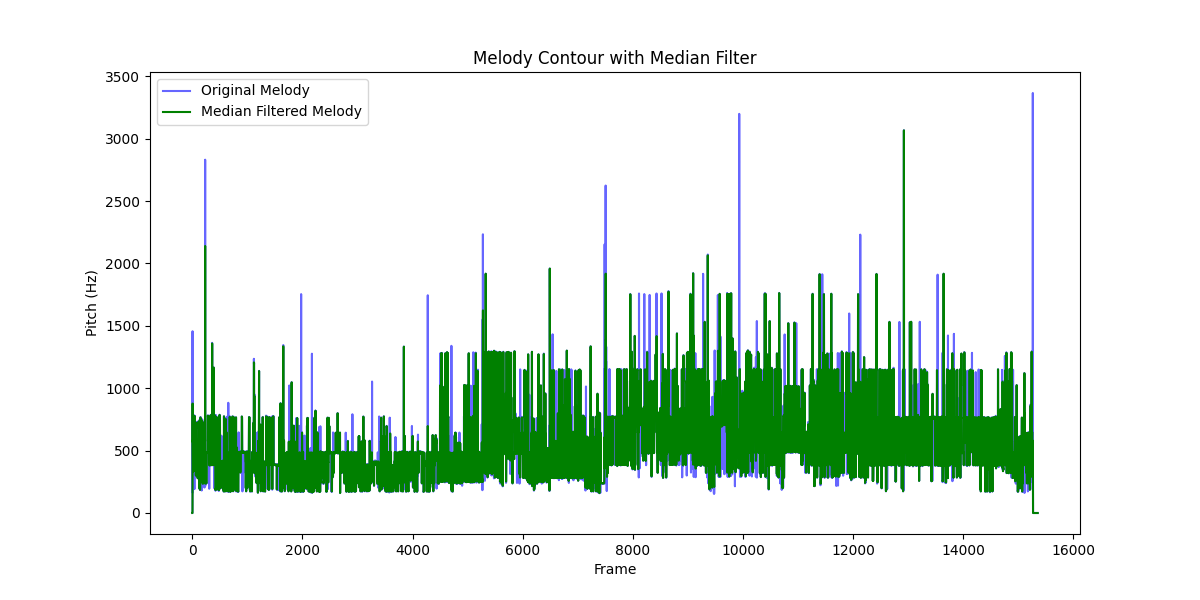

In [7]:
%matplotlib widget
root_dir = '/Users/josephbakarji/Documents/academic/research/music/ai-arabic/'
file_path = root_dir + 'data/recordings/saba--unknown_artist--Un_Voyage_Avec_Le_Oud_Arabe_2--06_Taqsim_Saba_(Baidaphon).mp3'
pitch_track = load_and_extract_melody(file_path)
filtered_pitch = apply_median_filter(pitch_track)

# Plot the original and filtered melody
plt.figure(figsize=(12, 6))
plt.plot(pitch_track, label="Original Melody", color='blue', alpha=0.6)
plt.plot(filtered_pitch, label="Median Filtered Melody", color='green')
plt.title("Melody Contour with Median Filter")
plt.xlabel("Frame")
plt.ylabel("Pitch (Hz)")
plt.legend()
plt.show()


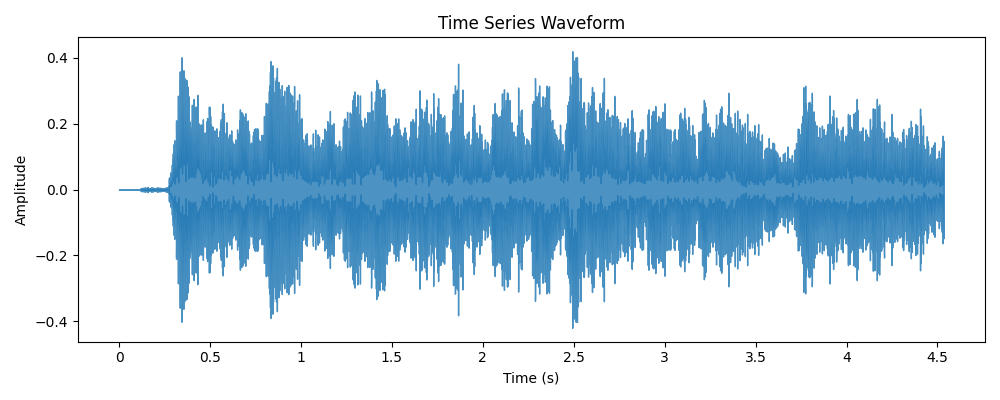

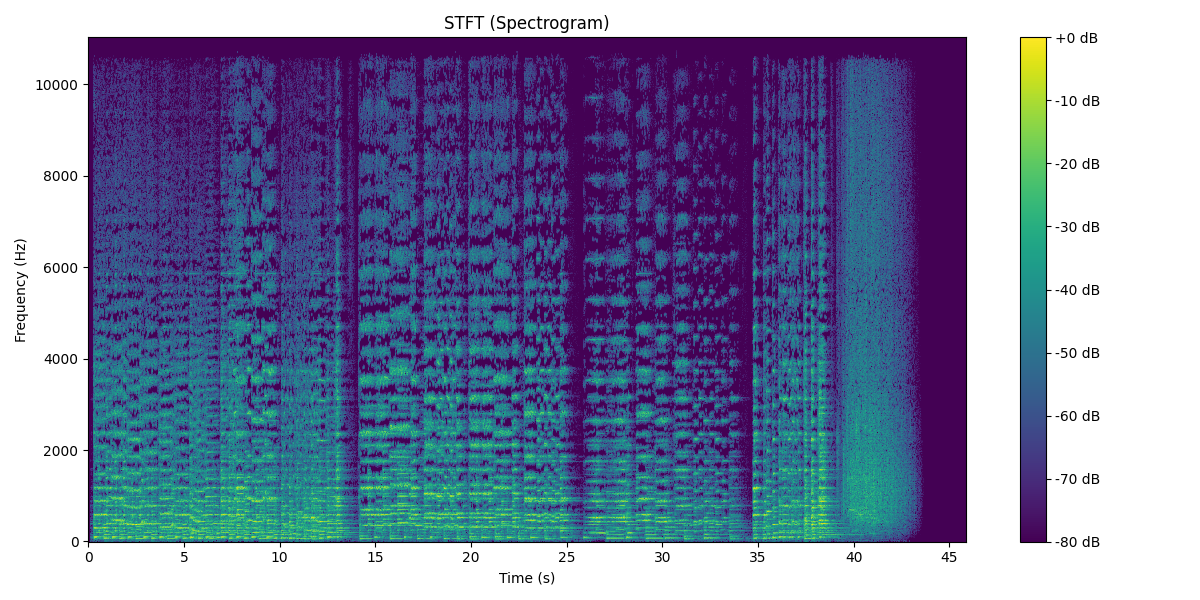

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load an example audio file for oud (you can replace this with your own file path)
audio_path = librosa.example('brahms')  # Replace with oud audio file path if available
y, sr = librosa.load(audio_path, sr=None)

# Visualize the time series waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y[:100000], sr=sr, alpha=0.8)
plt.title("Time Series Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Compute and visualize the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)  # Compute the STFT of the audio signal
DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("STFT (Spectrogram)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()


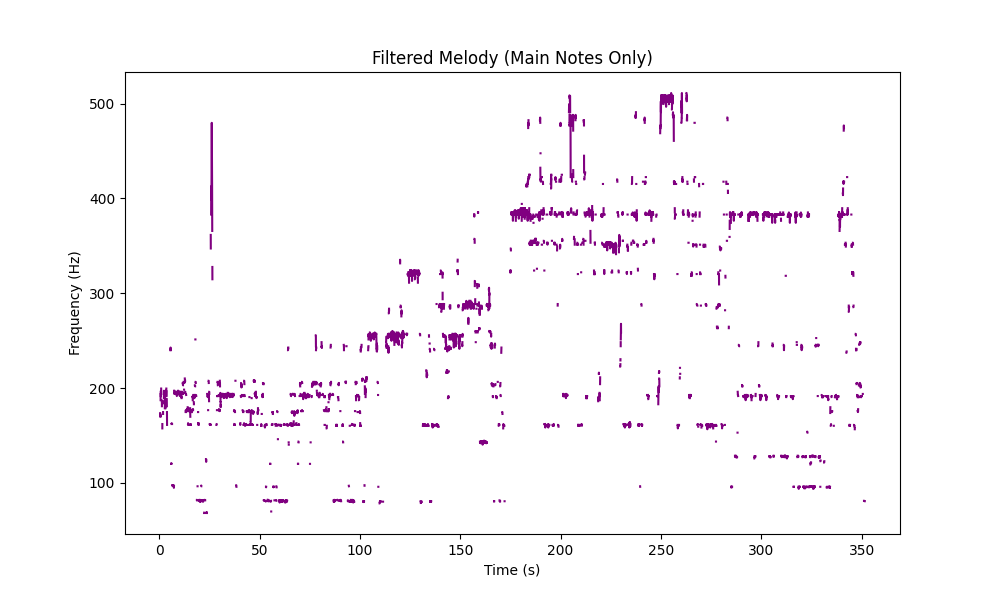

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def extract_melody_librosa(file_path, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), hop_length=512, threshold=0.2):
    y, sr = librosa.load(file_path, sr=None)

    # Use pyin to extract fundamental frequencies (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr, hop_length=hop_length)

    # Post-processing: apply median filter to smooth out short-term noise and spikes
    f0_smoothed = median_filter(f0, size=3)  # You can adjust the size for more or less smoothing

    # Filter out the frames where the voiced probability is too low (i.e., more likely noise)
    f0_filtered = np.where(voiced_probs > threshold, f0_smoothed, np.nan)

    # Plot the result
    plt.figure(figsize=(10, 6))
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    plt.plot(times, f0_filtered, color='purple')
    plt.title('Filtered Melody (Main Notes Only)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

    return f0_filtered

# Example usage:
melody_frequencies = extract_melody_librosa(file_path, threshold=0.3)  # Adjust threshold as needed


In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# First code: Extract all frequencies using piptrack
def extract_all_frequencies(file_path):
    y, sr = librosa.load(file_path)

    # Use harmonic-percussive source separation (HPS)
    y_harmonic, _ = librosa.effects.hpss(y)

    # Estimate pitch using piptrack
    pitches, magnitudes = librosa.core.piptrack(y=y_harmonic, sr=sr)

    # Extract the highest pitch at each time step
    frequencies = []
    times = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        if pitch > 0:  # Ignore pitch values of 0
            frequencies.append(pitch)
            times.append(t * (1/sr) * 512)  # Each frame corresponds to 512 samples

    return np.array(times), np.array(frequencies)

# Second code: Extract the main melody using pyin
def extract_melody_librosa(file_path, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), hop_length=512, threshold=0.2):
    y, sr = librosa.load(file_path, sr=None)

    # Use pyin to extract fundamental frequencies (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr, hop_length=hop_length)

    # Post-processing: apply median filter to smooth out short-term noise and spikes
    f0_smoothed = median_filter(f0, size=3)

    # Filter out the frames where the voiced probability is too low
    f0_filtered = np.where(voiced_probs > threshold, f0_smoothed, np.nan)

    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)

    return times, f0_filtered

# Combined plotting function
def plot_combined_frequencies(file_path):
    # Extract all frequencies (light gray)
    times_all, freqs_all = extract_all_frequencies(file_path)

    # Extract main melody frequencies (purple)
    times_melody, freqs_melody = extract_melody_librosa(file_path)

    # Plot both results
    plt.figure(figsize=(10, 6))

    # Plot all frequencies in light gray
    plt.plot(times_all, freqs_all, color='lightgray', label='All Frequencies')

    # Plot filtered melody in purple
    plt.plot(times_melody, freqs_melody, color='purple', label='Main Melody')

    plt.title('All Frequencies vs. Filtered Melody')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
file_path = '/content/Recording.mp3'
plot_combined_frequencies(file_path)


/var/folders/q4/_twpfpf54f3f6s17s74p67tc0000gp/T/ipykernel_49773/1081076225.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Recording.mp3'

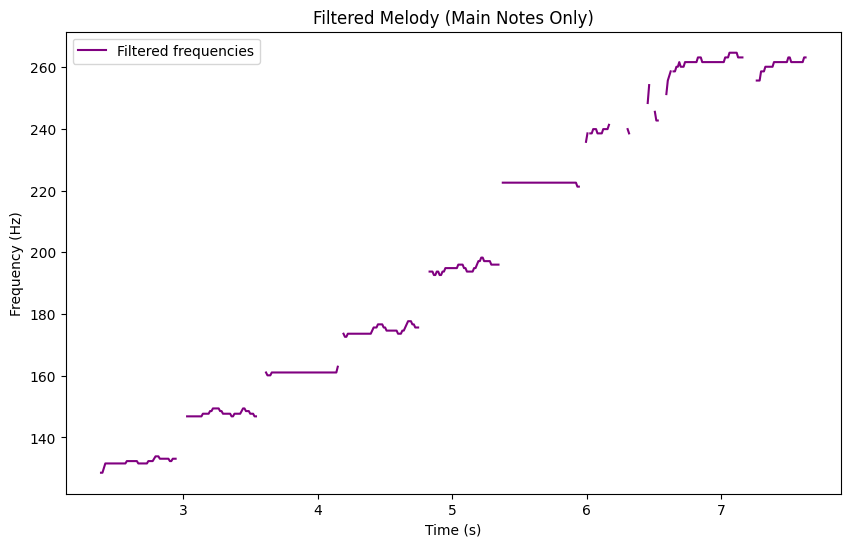

Extracted Frequencies: [128.56549734 128.56549734 130.05935646 131.57057339 131.57057339
 131.57057339 131.57057339 131.57057339 131.57057339 131.57057339
 131.57057339 131.57057339 131.57057339 131.57057339 131.57057339
 131.57057339 131.57057339 131.57057339 132.33275397 132.33275397
 132.33275397 132.33275397 132.33275397 132.33275397 132.33275397
 132.33275397 131.57057339 131.57057339 131.57057339 131.57057339
 131.57057339 131.57057339 131.57057339 132.33275397 132.33275397
 132.33275397 132.33275397 133.09934981 133.8703865  133.8703865
 133.8703865  133.09934981 133.09934981 133.09934981 133.09934981
 133.09934981 133.09934981 133.09934981 132.33275397 132.33275397
 133.09934981 133.09934981 133.09934981 146.83238396 146.83238396
 146.83238396 146.83238396 146.83238396 146.83238396 146.83238396
 146.83238396 146.83238396 146.83238396 146.83238396 147.68297531
 147.68297531 147.68297531 147.68297531 147.68297531 148.53849408
 148.53849408 149.39896882 149.39896882 149.39896882 1

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def extract_melody_librosa(file_path, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), hop_length=512, threshold=0.2):
    y, sr = librosa.load(file_path, sr=None)

    # Use pYIN to extract fundamental frequencies (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr, hop_length=hop_length)

    # Post-processing: apply median filter to smooth out short-term noise and spikes
    f0_smoothed = median_filter(f0, size=3)  # You can adjust the size for more or less smoothing

    # Filter out the frames where the voiced probability is too low (i.e., more likely noise)
    f0_filtered = np.where(voiced_probs > threshold, f0_smoothed, np.nan)

    # Plot the result
    plt.figure(figsize=(10, 6))
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    plt.plot(times, f0_filtered, color='purple', label='Filtered frequencies')
    plt.title('Filtered Melody (Main Notes Only)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()

    # Save frequencies to an array, filtering out NaN values which represent unvoiced sections
    valid_frequencies = f0_filtered[~np.isnan(f0_filtered)]

    return valid_frequencies

# Example usage:
file_path = '/content/Recording.mp3'
melody_frequencies = extract_melody_librosa(file_path, threshold=0.3)  # Adjust threshold as needed
print("Extracted Frequencies:", melody_frequencies)


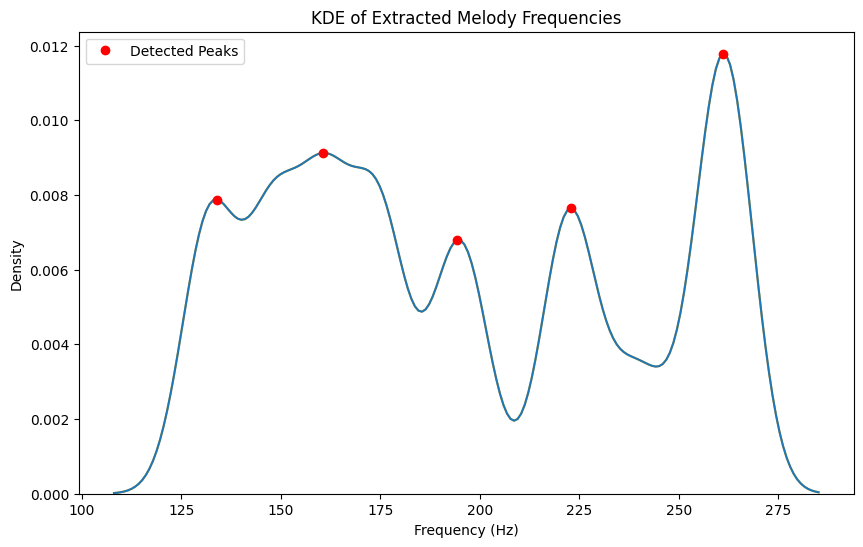

Prominent frequencies detected: [133.92154081 160.59982244 194.3923125  222.84914624 261.08801657]


In [ ]:
import seaborn as sns
from scipy.signal import find_peaks

def apply_kde_and_extract_peaks(frequencies, bandwidth=1.0):
    # Remove NaNs from the filtered frequencies (since KDE can't handle NaNs)
    clean_frequencies = frequencies[~np.isnan(frequencies)]

    # Apply Kernel Density Estimation (KDE) using seaborn's kdeplot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(clean_frequencies, bw_adjust=bandwidth, color='orange')
    plt.title('KDE of Extracted Melody Frequencies')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Density')

    # Extract data points from KDE for further analysis
    kde = sns.kdeplot(clean_frequencies, bw_adjust=bandwidth)
    kde_x = kde.get_lines()[0].get_xdata()
    kde_y = kde.get_lines()[0].get_ydata()

    # Find the peaks in the KDE curve to identify the most prominent frequencies
    peaks, _ = find_peaks(kde_y, height=0.001)  # Adjust height to capture peaks

    # Extract the prominent frequencies from the KDE curve
    prominent_frequencies = kde_x[peaks]

    # Plot the detected peaks
    plt.plot(prominent_frequencies, kde_y[peaks], 'ro', label='Detected Peaks')
    plt.legend()
    plt.show()

    return prominent_frequencies

# Apply KDE to the smoothed and filtered melody frequencies
prominent_frequencies = apply_kde_and_extract_peaks(melody_frequencies, bandwidth=0.5)

# Print the prominent frequencies for review
print("Prominent frequencies detected:", prominent_frequencies)


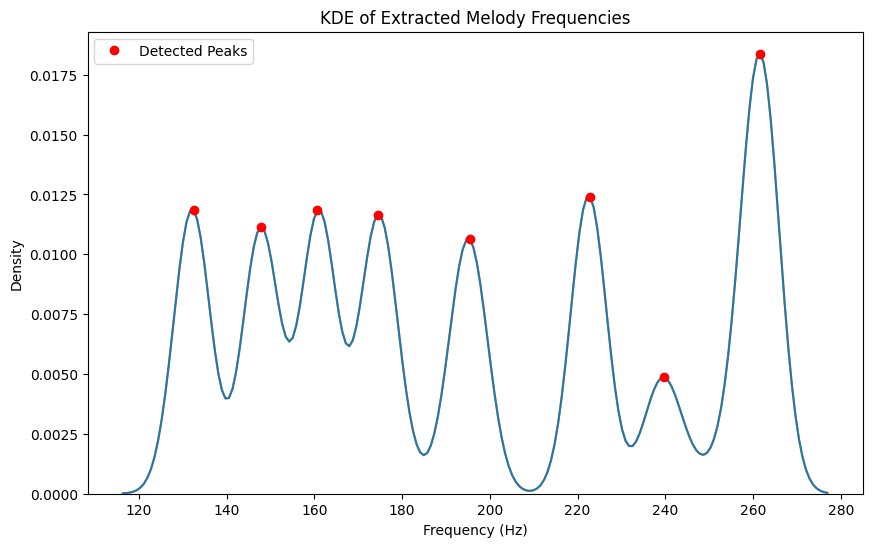

Prominent frequencies detected: [132.44838994 147.78392631 160.6980622  174.41933158 195.4048024
 222.84734116 239.79714452 261.58974883]


In [ ]:
import seaborn as sns
from scipy.signal import find_peaks

def apply_kde_and_extract_peaks(frequencies, bandwidth=0.3, peak_distance=10, peak_height=0.005):
    # Remove NaNs from the filtered frequencies (since KDE can't handle NaNs)
    clean_frequencies = frequencies[~np.isnan(frequencies)]

    # Apply Kernel Density Estimation (KDE) using seaborn's kdeplot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(clean_frequencies, bw_adjust=bandwidth, color='orange')
    plt.title('KDE of Extracted Melody Frequencies')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Density')

    # Extract data points from KDE for further analysis
    kde = sns.kdeplot(clean_frequencies, bw_adjust=bandwidth)
    kde_x = kde.get_lines()[0].get_xdata()
    kde_y = kde.get_lines()[0].get_ydata()

    # Adjust peak detection parameters (distance and height) to capture more peaks
    peaks, _ = find_peaks(kde_y, distance=peak_distance, height=peak_height)

    # Extract the prominent frequencies from the KDE curve
    prominent_frequencies = kde_x[peaks]

    # Plot the detected peaks
    plt.plot(prominent_frequencies, kde_y[peaks], 'ro', label='Detected Peaks')
    plt.legend()
    plt.show()

    return prominent_frequencies

# Apply KDE to the smoothed and filtered melody frequencies with refined parameters
prominent_frequencies = apply_kde_and_extract_peaks(melody_frequencies, bandwidth=0.3, peak_distance=5, peak_height=0.001)

# Print the prominent frequencies for review
print("Prominent frequencies detected:", prominent_frequencies)


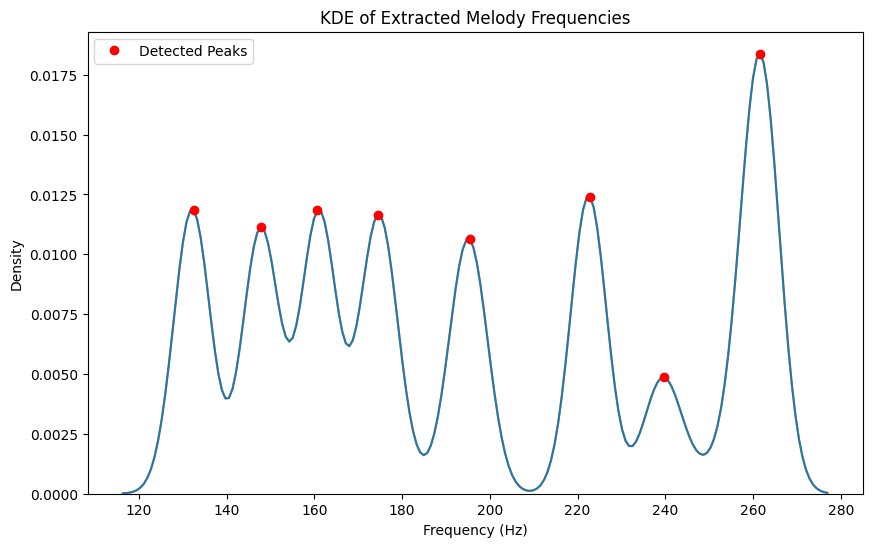

Intervals in cents between all frequencies:
             132.448390  147.783926  160.698062  174.419332  195.404802  \
132.448390     0.000000  189.670869  334.706671  476.555571  673.242742   
147.783926  -189.670869    0.000000  145.035802  286.884702  483.571873   
160.698062  -334.706671 -145.035802    0.000000  141.848900  338.536071   
174.419332  -476.555571 -286.884702 -141.848900    0.000000  196.687171   
195.404802  -673.242742 -483.571873 -338.536071 -196.687171    0.000000   
222.847341  -900.750530 -711.079661 -566.043859 -424.194959 -227.507788   
239.797145 -1027.661008 -837.990139 -692.954337 -551.105437 -354.418266   
261.589749 -1178.250839 -988.579971 -843.544168 -701.695269 -505.008098   

            222.847341   239.797145   261.589749  
132.448390  900.750530  1027.661008  1178.250839  
147.783926  711.079661   837.990139   988.579971  
160.698062  566.043859   692.954337   843.544168  
174.419332  424.194959   551.105437   701.695269  
195.404802  227.507788   

In [ ]:
import numpy as np
import pandas as pd

def calculate_all_intervals_in_cents(frequencies):
    num_freqs = len(frequencies)
    intervals_matrix = np.zeros((num_freqs, num_freqs))  # Initialize a matrix to store all the intervals

    # Calculate the interval in cents between every pair of frequencies
    for i in range(num_freqs):
        for j in range(num_freqs):
            if i != j:
                f1 = frequencies[i]
                f2 = frequencies[j]
                intervals_matrix[i, j] = 1200 * np.log2(f2 / f1)

    return intervals_matrix

# Apply KDE to the smoothed and filtered melody frequencies with refined parameters
prominent_frequencies = apply_kde_and_extract_peaks(melody_frequencies, bandwidth=0.3, peak_distance=5, peak_height=0.001)

# Calculate intervals in cents between all pairs of frequencies
intervals_matrix = calculate_all_intervals_in_cents(prominent_frequencies)

# Convert the matrix to a pandas DataFrame for better visualization
intervals_df = pd.DataFrame(intervals_matrix, columns=prominent_frequencies, index=prominent_frequencies)

# Print the intervals matrix for review
print("Intervals in cents between all frequencies:")
print(intervals_df)


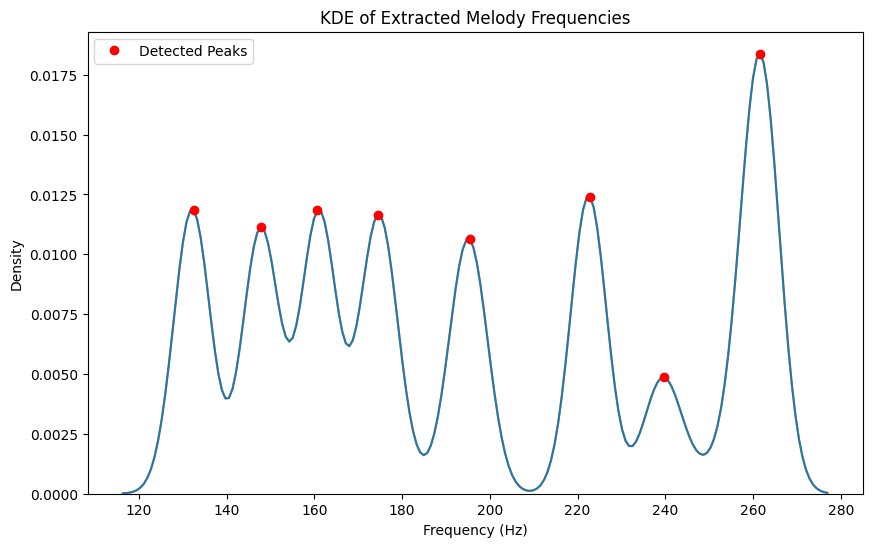

strictly positive intervals in cents between frequencies:
[ 189.67086879  334.70667111  476.55557076  673.24274177  900.75053007
 1027.66100776 1178.2508393   145.03580232  286.88470197  483.57187298
  711.07966128  837.99013897  988.57997051  141.84889965  338.53607066
  566.04385896  692.95433665  843.54416819  196.68717101  424.19495931
  551.105437    701.69526854  227.5077883   354.41826599  505.00809753
  126.91047769  277.50030923  150.58983154]


In [ ]:
import numpy as np

def calculate_positive_intervals_in_cents(frequencies):
    positive_intervals = []  # Initialize a list to store only positive intervals

    # Calculate the interval in cents between every pair of frequencies
    for i in range(len(frequencies)):
        for j in range(len(frequencies)):
            if i != j:
                f1 = frequencies[i]
                f2 = frequencies[j]
                interval = 1200 * np.log2(f2 / f1)

                # Add only positive intervals to the list
                if interval > 0:
                    positive_intervals.append(interval)

    return np.array(positive_intervals)  # Return as a flat NumPy array

# Assuming `melody_frequencies` is already defined and `apply_kde_and_extract_peaks` function exists
prominent_frequencies = apply_kde_and_extract_peaks(melody_frequencies, bandwidth=0.3, peak_distance=5, peak_height=0.001)

# Calculate strictly positive intervals in cents and store in a flat array
positive_intervals_array = calculate_positive_intervals_in_cents(prominent_frequencies)

# Print the array
print("strictly positive intervals in cents between frequencies:")
print(positive_intervals_array)


In [ ]:
import numpy as np

# Define distinctly different jins templates for testing
jins1 = [200, 400, 600]  # Just example values
jins2 = [100, 100, 500]
jins3 = [300, 500, 700]

# List of templates for easy iteration
jins_templates = {
    "Jins 1": jins1,
    "Jins 2": jins2,
    "Jins 3": jins3
}

def compare_intervals_to_jins(extracted_intervals):
    closest_jins = None
    min_difference = float('inf')

    # Compare extracted intervals to each jins template
    for jins_name, template in jins_templates.items():
        # Calculate the difference between the extracted intervals and the template
        difference = np.sum(np.abs(np.array(extracted_intervals) - np.array(template)))

        # Update if this template is the closest match so far
        if difference < min_difference:
            min_difference = difference
            closest_jins = jins_name

    return closest_jins, min_difference

# Example extracted intervals for testing
extracted_intervals = [250, 450, 550]

# Run the comparison
closest_jins, difference = compare_intervals_to_jins(extracted_intervals)

# Print the result
print(f"The extracted intervals are closest to {closest_jins} with a total difference of {difference} cents.")


The extracted intervals are closest to Jins 1 with a total difference of 150 cents.


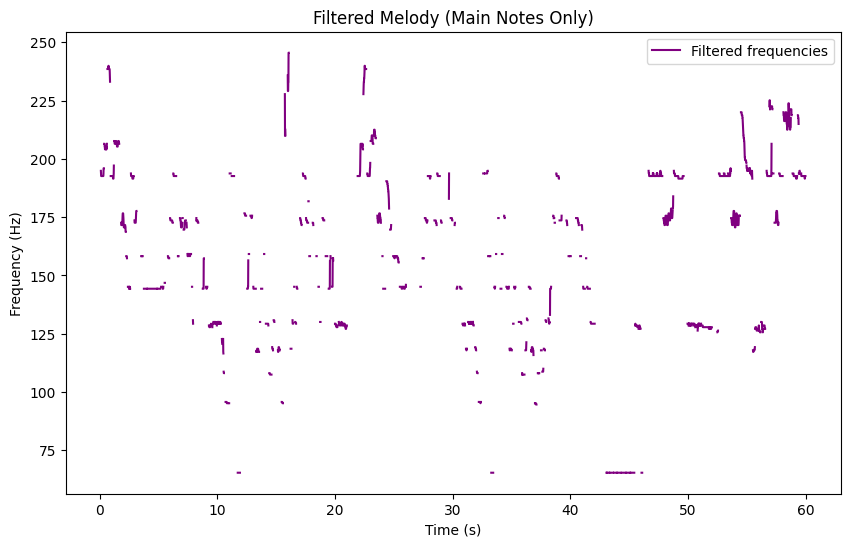

Extracted Frequencies: [194.8688542  193.74649219 192.63059451 ... 192.63059451 192.63059451
 192.63059451]


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def extract_melody_librosa(file_path, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), hop_length=512, frame_length=2048, threshold_ratio=0.1):
    # Load only the first two minutes of the audio file
    y, sr = librosa.load(file_path, sr=None, duration=60)

    # Use pYIN to extract fundamental frequencies (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr, hop_length=hop_length, frame_length=frame_length)

    # Calculate dynamic threshold based on median voiced probability
    dynamic_threshold = np.median(voiced_probs) * threshold_ratio

    # Post-processing: apply median filter to smooth out short-term noise and spikes
    f0_smoothed = median_filter(f0, size=5)  # Increased filter size for smoother transitions

    # Filter out the frames where the voiced probability is below the dynamic threshold
    f0_filtered = np.where(voiced_probs > dynamic_threshold, f0_smoothed, np.nan)

    # Plot the result
    plt.figure(figsize=(10, 6))
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    plt.plot(times, f0_filtered, color='purple', label='Filtered frequencies')
    plt.title('Filtered Melody (Main Notes Only)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()

    # Save frequencies to an array, filtering out NaN values which represent unvoiced sections
    valid_frequencies = f0_filtered[~np.isnan(f0_filtered)]

    return valid_frequencies

# Example usage:
file_path = '/content/01 Rast (8M 18S).mp3'
melody_frequencies = extract_melody_librosa(file_path, threshold_ratio=0.3)  # Adjust threshold as needed
print("Extracted Frequencies:", melody_frequencies)


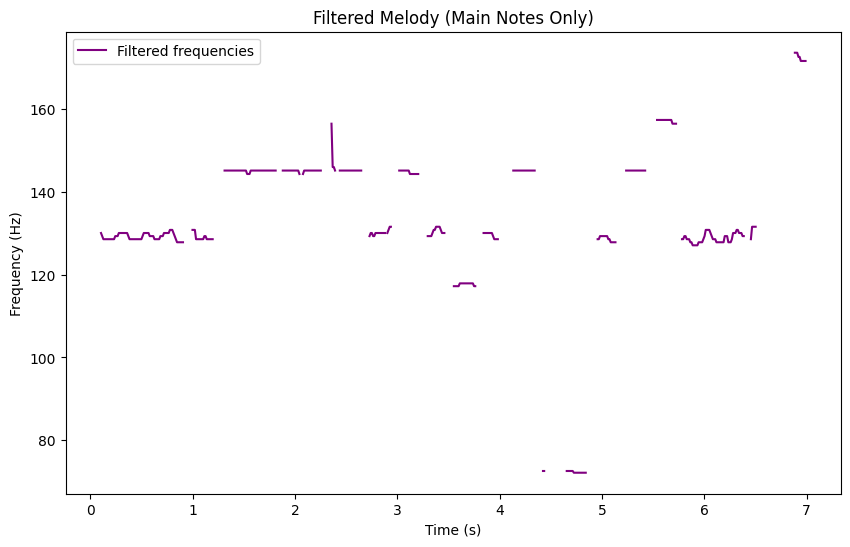

Extracted Frequencies: [130.05935646 129.31026969 128.56549734 128.56549734 128.56549734
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 128.56549734 128.56549734 129.31026969 129.31026969 129.31026969
 130.05935646 130.05935646 130.05935646 130.05935646 130.05935646
 130.05935646 130.05935646 130.05935646 129.31026969 128.56549734
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 129.31026969 130.05935646 130.05935646 130.05935646 130.05935646
 130.05935646 129.31026969 129.31026969 129.31026969 129.31026969
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 129.31026969 129.31026969 129.31026969 130.05935646 130.05935646
 130.05935646 130.05935646 130.05935646 130.81278265 130.81278265
 130.81278265 130.05935646 129.31026969 128.56549734 127.82501457
 127.82501457 127.82501457 127.82501457 127.82501457 127.82501457
 130.81278265 130.81278265 130.81278265 128.56549734 

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def extract_melody_librosa(file_path, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), hop_length=512, frame_length=2048, threshold_ratio=0.1):
    # Load only the first two minutes of the audio file
    y, sr = librosa.load(file_path, sr=None, duration=7)

    # Use pYIN to extract fundamental frequencies (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr, hop_length=hop_length, frame_length=frame_length)

    # Calculate dynamic threshold based on median voiced probability
    dynamic_threshold = np.median(voiced_probs) * threshold_ratio

    # Post-processing: apply median filter to smooth out short-term noise and spikes
    f0_smoothed = median_filter(f0, size=5)  # Increased filter size for smoother transitions

    # Filter out the frames where the voiced probability is below the dynamic threshold
    f0_filtered = np.where(voiced_probs > dynamic_threshold, f0_smoothed, np.nan)

    # Plot the result
    plt.figure(figsize=(10, 6))
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    plt.plot(times, f0_filtered, color='purple', label='Filtered frequencies')
    plt.title('Filtered Melody (Main Notes Only)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()

    # Save frequencies to an array, filtering out NaN values which represent unvoiced sections
    valid_frequencies = f0_filtered[~np.isnan(f0_filtered)]

    return valid_frequencies

# Example usage:
file_path = '/content/02 Bayati (7M 39S).mp3'
melody_frequencies = extract_melody_librosa(file_path, threshold_ratio=0.3)  # Adjust threshold as needed
print("Extracted Frequencies:", melody_frequencies)


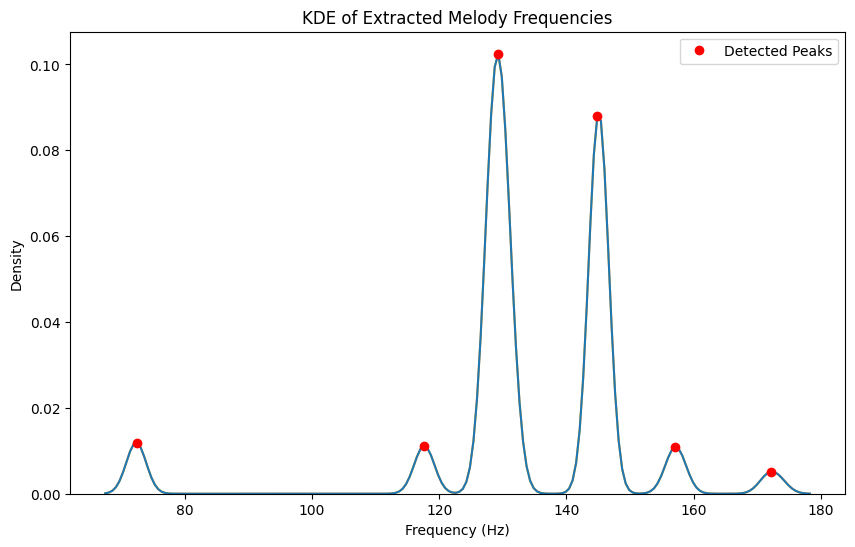

Prominent frequencies detected: [ 72.48717889 117.59164867 129.2854001  144.87706867 157.1276654
 172.16248866]


In [ ]:
import seaborn as sns
from scipy.signal import find_peaks

def apply_kde_and_extract_peaks(frequencies, bandwidth=0.3, peak_distance=10, peak_height=0.005):
    # Remove NaNs from the filtered frequencies (since KDE can't handle NaNs)
    clean_frequencies = frequencies[~np.isnan(frequencies)]

    # Apply Kernel Density Estimation (KDE) using seaborn's kdeplot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(clean_frequencies, bw_adjust=bandwidth, color='orange')
    plt.title('KDE of Extracted Melody Frequencies')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Density')

    # Extract data points from KDE for further analysis
    kde = sns.kdeplot(clean_frequencies, bw_adjust=bandwidth)
    kde_x = kde.get_lines()[0].get_xdata()
    kde_y = kde.get_lines()[0].get_ydata()

    # Adjust peak detection parameters (distance and height) to capture more peaks
    peaks, _ = find_peaks(kde_y, distance=peak_distance, height=peak_height)

    # Extract the prominent frequencies from the KDE curve
    prominent_frequencies = kde_x[peaks]

    # Plot the detected peaks
    plt.plot(prominent_frequencies, kde_y[peaks], 'ro', label='Detected Peaks')
    plt.legend()
    plt.show()

    return prominent_frequencies

# Apply KDE to the smoothed and filtered melody frequencies with refined parameters
prominent_frequencies = apply_kde_and_extract_peaks(melody_frequencies, bandwidth=0.3, peak_distance=5, peak_height=0.001)

# Print the prominent frequencies for review
print("Prominent frequencies detected:", prominent_frequencies)


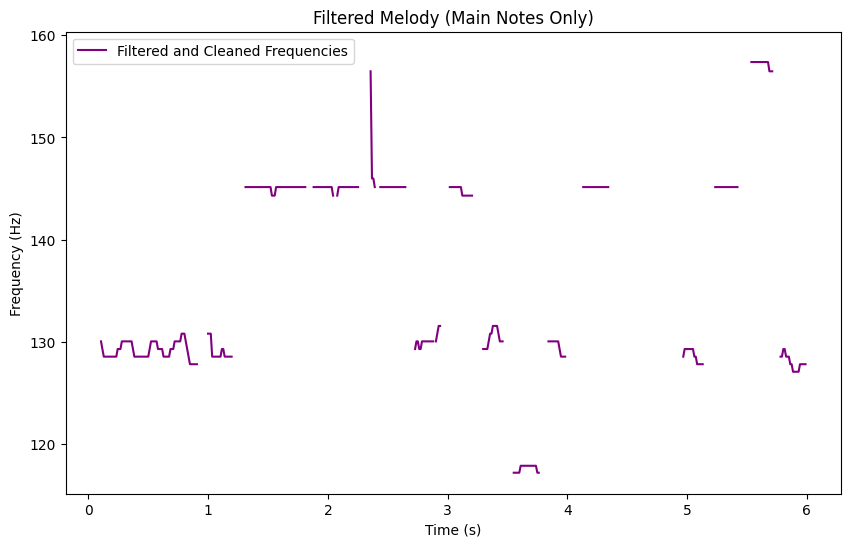

Extracted Frequencies: [130.05935646 129.31026969 128.56549734 128.56549734 128.56549734
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 128.56549734 128.56549734 129.31026969 129.31026969 129.31026969
 130.05935646 130.05935646 130.05935646 130.05935646 130.05935646
 130.05935646 130.05935646 130.05935646 129.31026969 128.56549734
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 129.31026969 130.05935646 130.05935646 130.05935646 130.05935646
 130.05935646 129.31026969 129.31026969 129.31026969 129.31026969
 128.56549734 128.56549734 128.56549734 128.56549734 128.56549734
 129.31026969 129.31026969 129.31026969 130.05935646 130.05935646
 130.05935646 130.05935646 130.05935646 130.81278265 130.81278265
 130.81278265 130.05935646 129.31026969 128.56549734 127.82501457
 127.82501457 127.82501457 127.82501457 127.82501457 127.82501457
 130.81278265 130.81278265 130.81278265 128.56549734 

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def remove_outliers(data):
    q1 = np.nanpercentile(data, 25)
    q3 = np.nanpercentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return np.where((data > lower_bound) & (data < upper_bound), data, np.nan)

def extract_melody_librosa(file_path, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), hop_length=512, frame_length=2048, threshold_ratio=0.1):
    # Load only the first two minutes of the audio file
    y, sr = librosa.load(file_path, sr=None, duration=6)

    # Use pYIN to extract fundamental frequencies (f0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax, sr=sr, hop_length=hop_length, frame_length=frame_length)

    # Calculate dynamic threshold based on median voiced probability
    dynamic_threshold = np.median(voiced_probs) * threshold_ratio

    # Post-processing: apply median filter to smooth out short-term noise and spikes
    f0_smoothed = median_filter(f0, size=5)  # Increased filter size for smoother transitions

    # Filter out the frames where the voiced probability is below the dynamic threshold
    f0_filtered = np.where(voiced_probs > dynamic_threshold, f0_smoothed, np.nan)

    # Remove outliers
    f0_cleaned = remove_outliers(f0_filtered)

    # Plot the result
    plt.figure(figsize=(10, 6))
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    plt.plot(times, f0_cleaned, color='purple', label='Filtered and Cleaned Frequencies')
    plt.title('Filtered Melody (Main Notes Only)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()

    # Save frequencies to an array, filtering out NaN values which represent unvoiced sections
    valid_frequencies = f0_cleaned[~np.isnan(f0_cleaned)]

    return valid_frequencies

# Example usage:
file_path = '/content/02 Bayati (7M 39S).mp3'
melody_frequencies = extract_melody_librosa(file_path, threshold_ratio=0.3)  # Adjust threshold as needed
print("Extracted Frequencies:", melody_frequencies)


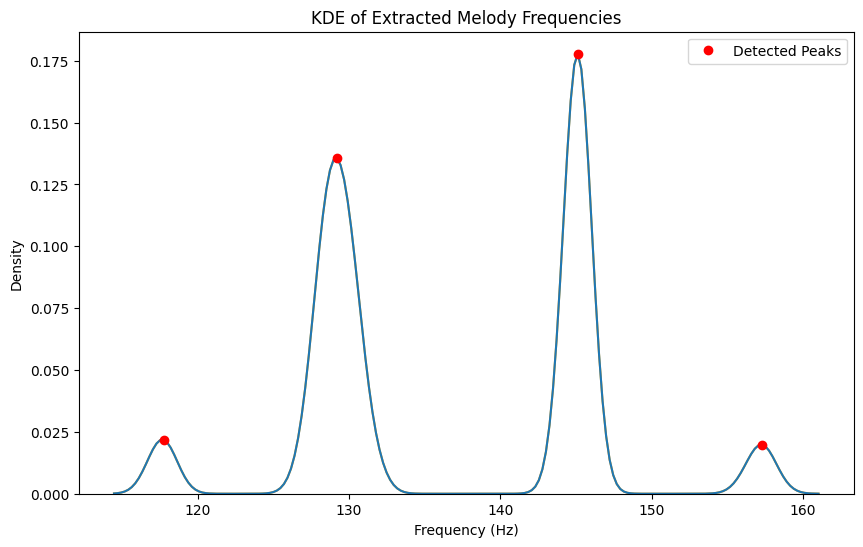

Prominent frequencies detected: [117.74242159 129.2083946  145.12035714 157.28832849]


In [ ]:
import seaborn as sns
from scipy.signal import find_peaks

def apply_kde_and_extract_peaks(frequencies, bandwidth=0.3, peak_distance=10, peak_height=0.005):
    # Remove NaNs from the filtered frequencies (since KDE can't handle NaNs)
    clean_frequencies = frequencies[~np.isnan(frequencies)]

    # Apply Kernel Density Estimation (KDE) using seaborn's kdeplot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(clean_frequencies, bw_adjust=bandwidth, color='orange')
    plt.title('KDE of Extracted Melody Frequencies')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Density')

    # Extract data points from KDE for further analysis
    kde = sns.kdeplot(clean_frequencies, bw_adjust=bandwidth)
    kde_x = kde.get_lines()[0].get_xdata()
    kde_y = kde.get_lines()[0].get_ydata()

    # Adjust peak detection parameters (distance and height) to capture more peaks
    peaks, _ = find_peaks(kde_y, distance=peak_distance, height=peak_height)

    # Extract the prominent frequencies from the KDE curve
    prominent_frequencies = kde_x[peaks]

    # Plot the detected peaks
    plt.plot(prominent_frequencies, kde_y[peaks], 'ro', label='Detected Peaks')
    plt.legend()
    plt.show()

    return prominent_frequencies

# Apply KDE to the smoothed and filtered melody frequencies with refined parameters
prominent_frequencies = apply_kde_and_extract_peaks(melody_frequencies, bandwidth=0.3, peak_distance=5, peak_height=0.001)

# Print the prominent frequencies for review
print("Prominent frequencies detected:", prominent_frequencies)
